In [118]:
import pandas as pd
import numpy as np

data = pd.read_csv('OpenMATB\sessions\\2023-12-07\Session 2\\2_231207_141455.csv')
performance_data = data[data.apply(lambda row: row.astype(str).str.contains('performance', case=False).any(), axis=1)]
output_file_path = 'OpenMATB\sessions\\2023-12-07\Session 2\\2_231207_141455_performance.csv'
performance_data.to_csv(output_file_path, index=False)
print(performance_data.head(10))


          logtime  scenario_time         type  module           address  \
179  19738.569977       0.191847  performance  resman    a_in_tolerance   
180  19738.570021       0.191847  performance  resman       a_deviation   
181  19738.570039       0.191847  performance  resman    b_in_tolerance   
182  19738.570053       0.191847  performance  resman       b_deviation   
215  19738.579427       0.201076  performance   track  cursor_in_target   
216  19738.579453       0.201076  performance   track  center_deviation   
333  19738.612653       0.234198  performance   track  cursor_in_target   
334  19738.612677       0.234198  performance   track  center_deviation   
387  19738.638181       0.258561  performance   track  cursor_in_target   
388  19738.638200       0.258561  performance   track  center_deviation   

        value  
179         1  
180         0  
181         0  
182      1500  
215         1  
216       0.0  
333         1  
334  2.429249  
387         1  
388  3.643778 

## Track - sekcija

In [120]:
from sklearn.model_selection import train_test_split
track_data = performance_data[
    performance_data.apply(
        lambda row: row.astype(str).str.contains('track', case=False).any() and 
                    row.astype(str).str.contains('center_deviation', case=False).any(),
        axis=1
    )
]

track_data['value'] = pd.to_numeric(track_data['value'], errors='coerce')
numeric_columns = track_data.select_dtypes(include='number').columns.tolist()
track_data_encoded = track_data[numeric_columns]
print(track_data_encoded)


            logtime  scenario_time     value
216    19738.579453       0.201076  0.000000
334    19738.612677       0.234198  2.429249
388    19738.638200       0.258561  3.643778
499    19738.662031       0.283181  4.858192
567    19741.342660       0.314210  6.072453
...             ...            ...       ...
17747  19800.925412      59.897074  7.083583
17755  19800.959509      59.931042  7.306294
17764  19800.993053      59.964153  7.522391
17784  19801.025391      59.996841  7.745505
17796  19801.059191      60.030697  7.975463

[1797 rows x 3 columns]


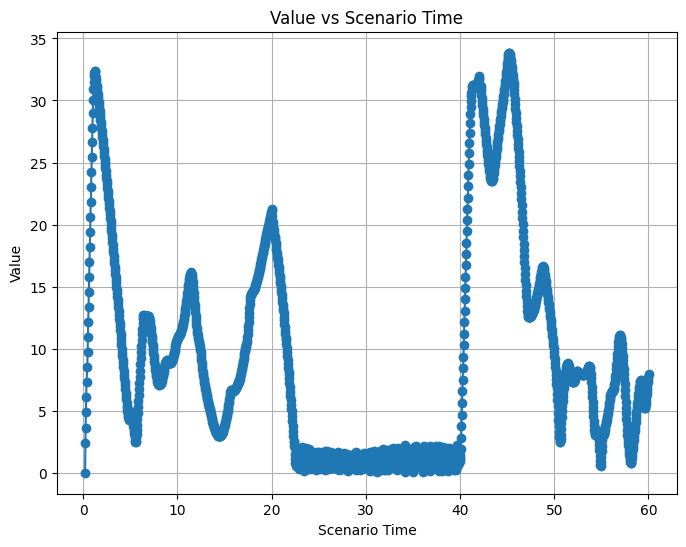

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(track_data_encoded['scenario_time'], track_data_encoded['value'], marker='o', linestyle='-')
plt.xlabel('Scenario Time')
plt.ylabel('Value')
plt.title('Value vs Scenario Time')
plt.grid(True)
plt.show()

In [122]:
y_track = track_data_encoded['value'].values
X_track = track_data_encoded.drop(columns=['value'])
X_train, X_test, y_train, y_test = train_test_split(X_track, y_track, test_size=0.2, shuffle=False)

In [178]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
import keras as keras

time_steps = 100 
X_train_sequence = []
y_train_sequence = []
for i in range(len(X_train) - time_steps):
    X_train_sequence.append(X_train.iloc[i:i+time_steps].values)
    y_train_sequence.append(y_train[i+time_steps])

X_train_sequence = np.array(X_train_sequence)
y_train_sequence = np.array(y_train_sequence)
y_train_sequence = np.asarray(y_train_sequence).astype(np.float32)
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_sequence.shape[1], X_train_sequence.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(200, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Dense(1))
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train_sequence, y_train_sequence, epochs=20, batch_size=8)



Epoch 1/20
168/168 [==============================] - 8s 14ms/step - loss: 98.1792
Epoch 2/20
168/168 [==============================] - 2s 13ms/step - loss: 88.1620
Epoch 3/20
168/168 [==============================] - 2s 13ms/step - loss: 89.0632
Epoch 4/20
168/168 [==============================] - 2s 13ms/step - loss: 89.0413
Epoch 5/20
168/168 [==============================] - 2s 13ms/step - loss: 89.0623
Epoch 6/20
168/168 [==============================] - 2s 13ms/step - loss: 88.0505
Epoch 7/20
168/168 [==============================] - 2s 13ms/step - loss: 88.6699
Epoch 8/20
168/168 [==============================] - 2s 13ms/step - loss: 88.0054
Epoch 9/20
168/168 [==============================] - 2s 13ms/step - loss: 88.5340
Epoch 10/20
168/168 [==============================] - 2s 13ms/step - loss: 88.7765
Epoch 11/20
168/168 [==============================] - 2s 13ms/step - loss: 88.4725
Epoch 12/20
168/168 [==============================] - 2s 13ms/step - loss: 88.5183
E

In [130]:
X_test_sequence = []
y_test_sequence = []
for i in range(len(X_test) - time_steps):
    X_test_sequence.append(X_test.iloc[i:i+time_steps].values)
    y_test_sequence.append(y_test[i+time_steps])

X_test_sequence = np.array(X_test_sequence)
y_test_sequence = np.array(y_test_sequence)
X_test_sequence = np.reshape(X_test_sequence, (X_test_sequence.shape[0], X_test_sequence.shape[1], X_test_sequence.shape[2]))

y_pred = model.predict(X_test_sequence)
mae = mean_absolute_error(y_test_sequence, y_pred)
print("Mean Absolute Error (MAE) on test set:", mae)

9/9 [==============================] - 4s 30ms/step
Mean Absolute Error (MAE) on test set: 3.151441168669246


## Resman - sekcija

In [142]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

In [154]:
resman_data = performance_data[
    performance_data.apply(
        lambda row: row.astype(str).str.contains('resman', case=False).any() and 
                    row.astype(str).str.contains('a_deviation', case=False).any() or row.astype(str).str.contains('b_deviation', case=False).any(),
        axis=1
    )
]

resman_data['value'] = pd.to_numeric(resman_data['value'], errors='coerce')
resman_data = handle_non_numerical_data(resman_data)
numeric_columns = resman_data.select_dtypes(include='number').columns.tolist()
resman_data_encoded = resman_data[numeric_columns]
print(resman_data_encoded)

            logtime  scenario_time  type  module  address  value
180    19738.570021       0.191847     0       0        0      0
182    19738.570053       0.191847     0       0        1   1500
1151   19743.231038       2.202012     0       0        0      7
1153   19743.231086       2.202012     0       0        1   1461
1774   19745.244177       4.215780     0       0        0      1
1776   19745.244216       4.215780     0       0        1   1435
2386   19747.259379       6.230719     0       0        0     -5
2388   19747.259425       6.230719     0       0        1   1409
3000   19749.270997       8.242722     0       0        0    -11
3002   19749.271048       8.242722     0       0        1   1383
3612   19751.288176      10.258896     0       0        0    -17
3614   19751.288215      10.258896     0       0        1   1357
4230   19753.301235      12.272801     0       0        0    -23
4232   19753.301270      12.272801     0       0        1   1331
4843   19755.319149      

In [158]:
y_resman = resman_data_encoded['value'].values
X_resman = resman_data_encoded.drop(columns=['value'])
X_train_resman, X_test_resman, y_train_resman, y_test_resman = train_test_split(X_resman, y_resman, test_size=0.2, shuffle=False)

(60, 5)


In [167]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
import keras as keras

time_steps = 10
X_train_sequence_resman = []
y_train_sequence_resman = []
for i in range(len(X_train_resman) - time_steps):
    X_train_sequence_resman.append(X_train_resman.iloc[i:i+time_steps].values)
    y_train_sequence_resman.append(y_train_resman[i+time_steps])

X_train_sequence_resman = np.array(X_train_sequence_resman)
y_train_sequence_resman = np.array(y_train_sequence_resman)
y_train_sequence_resman = np.asarray(y_train_sequence_resman).astype(np.float32)
model_resman = Sequential()
model_resman.add(LSTM(units=10, return_sequences=True, input_shape=(X_train_sequence_resman.shape[1], X_train_sequence_resman.shape[2])))
model_resman.add(Dropout(0.2))
model_resman.add(LSTM(20, return_sequences=False))
model_resman.add(Dropout(0.2))
model_resman.add(Dense(1))
optimizer = Adam(lr=0.0001)

model_resman.compile(optimizer=optimizer, loss='mean_squared_error')
model_resman.fit(X_train_sequence_resman, y_train_sequence_resman, epochs=20, batch_size=8)



Epoch 1/20
5/5 [==============================] - 5s 17ms/step - loss: 644177.8125
Epoch 2/20
5/5 [==============================] - 0s 16ms/step - loss: 644124.3750
Epoch 3/20
5/5 [==============================] - 0s 16ms/step - loss: 644096.4375
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 644160.3125
Epoch 5/20
5/5 [==============================] - 0s 13ms/step - loss: 644077.8125
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 644080.8125
Epoch 7/20
5/5 [==============================] - 0s 11ms/step - loss: 644055.5000
Epoch 8/20
5/5 [==============================] - 0s 11ms/step - loss: 644097.8750
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 644042.6250
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 644030.5000
Epoch 11/20
5/5 [==============================] - 0s 11ms/step - loss: 644091.6875
Epoch 12/20
5/5 [==============================] - 0s 10ms/step - loss: 644038.6250
E

In [169]:
X_test_sequence_resman = []
y_test_sequence_resman = []
for i in range(len(X_test_resman) - time_steps):
    X_test_sequence_resman.append(X_test_resman.iloc[i:i+time_steps].values)
    y_test_sequence_resman.append(y_test_resman[i+time_steps])

X_test_sequence_resman = np.array(X_test_sequence_resman)
y_test_sequence_resman = np.array(y_test_sequence_resman)
X_test_sequence_resman = np.reshape(X_test_sequence_resman, (X_test_sequence_resman.shape[0], X_test_sequence_resman.shape[1], X_test_sequence_resman.shape[2]))

y_pred_resman = model_resman.predict(X_test_sequence_resman)
mae_resman = mean_absolute_error(y_test_sequence_resman, y_pred_resman)
print("Mean Absolute Error (MAE) on test set:", mae_resman)

1/1 [==============================] - 2s 2s/step
Mean Absolute Error (MAE) on test set: 519.6322579085827
